* Fiftyone python library
* Fiftyone app: desktop / web ()
* Fiftyone Brain

In [1]:
import fiftyone as fo
from fiftyone import ViewField as F
import pandas as pd
import numpy as np
import os
import json
from ast import literal_eval
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
# defining relative paths
parent_dir = os.path.dirname(os.path.abspath(os.getcwd()))
dataset_dir = os.path.join(parent_dir, "data")
imgdata_dir = os.path.join(dataset_dir,"img")

In [3]:
classes = ["Not_Checkworthy", "Checkworthy"]

### Functions to Load Data

In [4]:
def create_classification_label(binary_label, confidence=None):
    verbose_label = "Checkworthy" if binary_label else "Not_Checkworthy"
    label = fo.Classification(label=verbose_label, binary_label=binary_label)
    if confidence!= None:
        label.confidence = confidence
        label_prob = confidence
        other_prob = 1-confidence
        label.logits = [other_prob, label_prob] if binary_label else [label_prob, other_prob]
    return label
    

In [5]:
def load_from_df(df, dataset):
    for index, row in df.iterrows():

        file_name = str(row.tweet_id) + ".png"
        file_path = os.path.join(imgdata_dir,file_name)

        metadata = fo.ImageMetadata.build_for(file_path)

        ground_truth = create_classification_label(row.check_worthiness)
        bert_prediction = create_classification_label(row.bert_predictions, row.bert_probability)
        roberta_prediction = create_classification_label(row.roberta_predictions, row.roberta_probability)
        bertweet_prediction = create_classification_label(row.bertweet_predictions, row.bertweet_probability)
        bertweet_filtered_prediction = create_classification_label(row.bertweet_filtered_predictions, row.bertweet_filtered_probability)
        gpt3_prediction = create_classification_label(row.gpt3_predictions, row.gpt3_probability)

        sample = fo.Sample(
            filepath=file_path, 
            metadata=metadata, 
            ground_truth = ground_truth, 
            bert_prediction = bert_prediction,
            roberta_prediction = roberta_prediction,
            bertweet_prediction = bertweet_prediction,
            bertweet_filtered_prediction = bertweet_filtered_prediction,
            gpt3_prediction = gpt3_prediction
            )

        sample.tags.append("Validation")
        dataset.add_sample(sample)

### Creating Dataset and Loading Data

In [32]:
dataset_name = "tweet_dataset"

In [41]:
# If you created a dataset with the same name before and create the dataset from scratch, just delete the previous dataset
fo.delete_dataset(dataset_name)

In [42]:
try:
    dataset = fo.Dataset(dataset_name)
except:
    dataset = fo.load_dataset(dataset_name)

In [9]:
eval_df = pd.read_csv(os.path.join(dataset_dir,"eval_df.csv"))
eval_df["embeddings"] = eval_df.embeddings.apply(json.loads)
eval_df["embeddings"] = eval_df["embeddings"].apply(lambda x: np.asanyarray(x))


In [10]:
eval_df.head(3)

,tweet_id,tweet_url,tweet_text,check_worthiness,bert_predictions,bert_probability,roberta_predictions,roberta_probability,bertweet_predictions,bertweet_probability,gpt3_predictions,gpt3_probability,embeddings,bertweet_filtered_predictions,bertweet_filtered_probability
0,1237160250513522688,https://twitter.com/user/status/12371602505135...,POTUS wanted everyone to know he was in close ...,1,1,0.993853,1,0.983054,1,0.988866,1,0.890893,"[-0.0495423786342144, -0.2645258903503418, -0....",1,0.987442
1,1237125962871037953,https://twitter.com/user/status/12371259628710...,Who would you prefer to lead our nation’s resp...,0,0,0.000108,0,0.006362,0,0.006661,0,0.999922,"[-0.0495423786342144, -0.2645258903503418, -0....",0,0.007730
2,1237207721604235264,https://twitter.com/user/status/12372077216042...,It was a really really really really really re...,0,0,0.000569,0,0.004905,0,0.007607,0,0.959031,"[-0.0495423786342144, -0.2645258903503418, -0....",0,0.008914


In [21]:
ordered_label_issues = [ 63,  56,  95, 120,  38,  22, 104, 107,  88, 134,  32,  44, 139,
        55,  15,  23,  51, 119, 100, 121,  42,  59,  20,  47,  76,  29,
        19, 101,  78,  75,  31,  26] # predicted by cleanlab

In [25]:
len(ordered_label_issues)

32

In [28]:
filtered_eval_df = eval_df[eval_df.index.isin(ordered_label_issues)==False]

In [43]:
load_from_df(eval_df, dataset)

In [61]:
print(dataset)

Name:        tweet_dataset
Media type:  image
Num samples: 140
Persistent:  False
Tags:        []
Sample fields:
    id:                           fiftyone.core.fields.ObjectIdField
    filepath:                     fiftyone.core.fields.StringField
    tags:                         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth:                 fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    bert_prediction:              fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    roberta_prediction:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    bertweet_prediction:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    bertweet_filtered_prediction: fiftyone.core.fields.EmbeddedDocumentField(fift

### GUI of FiftyOne

In [70]:
session = fo.launch_app(dataset.sort_by("gpt3_mistakeness"), desktop=False)


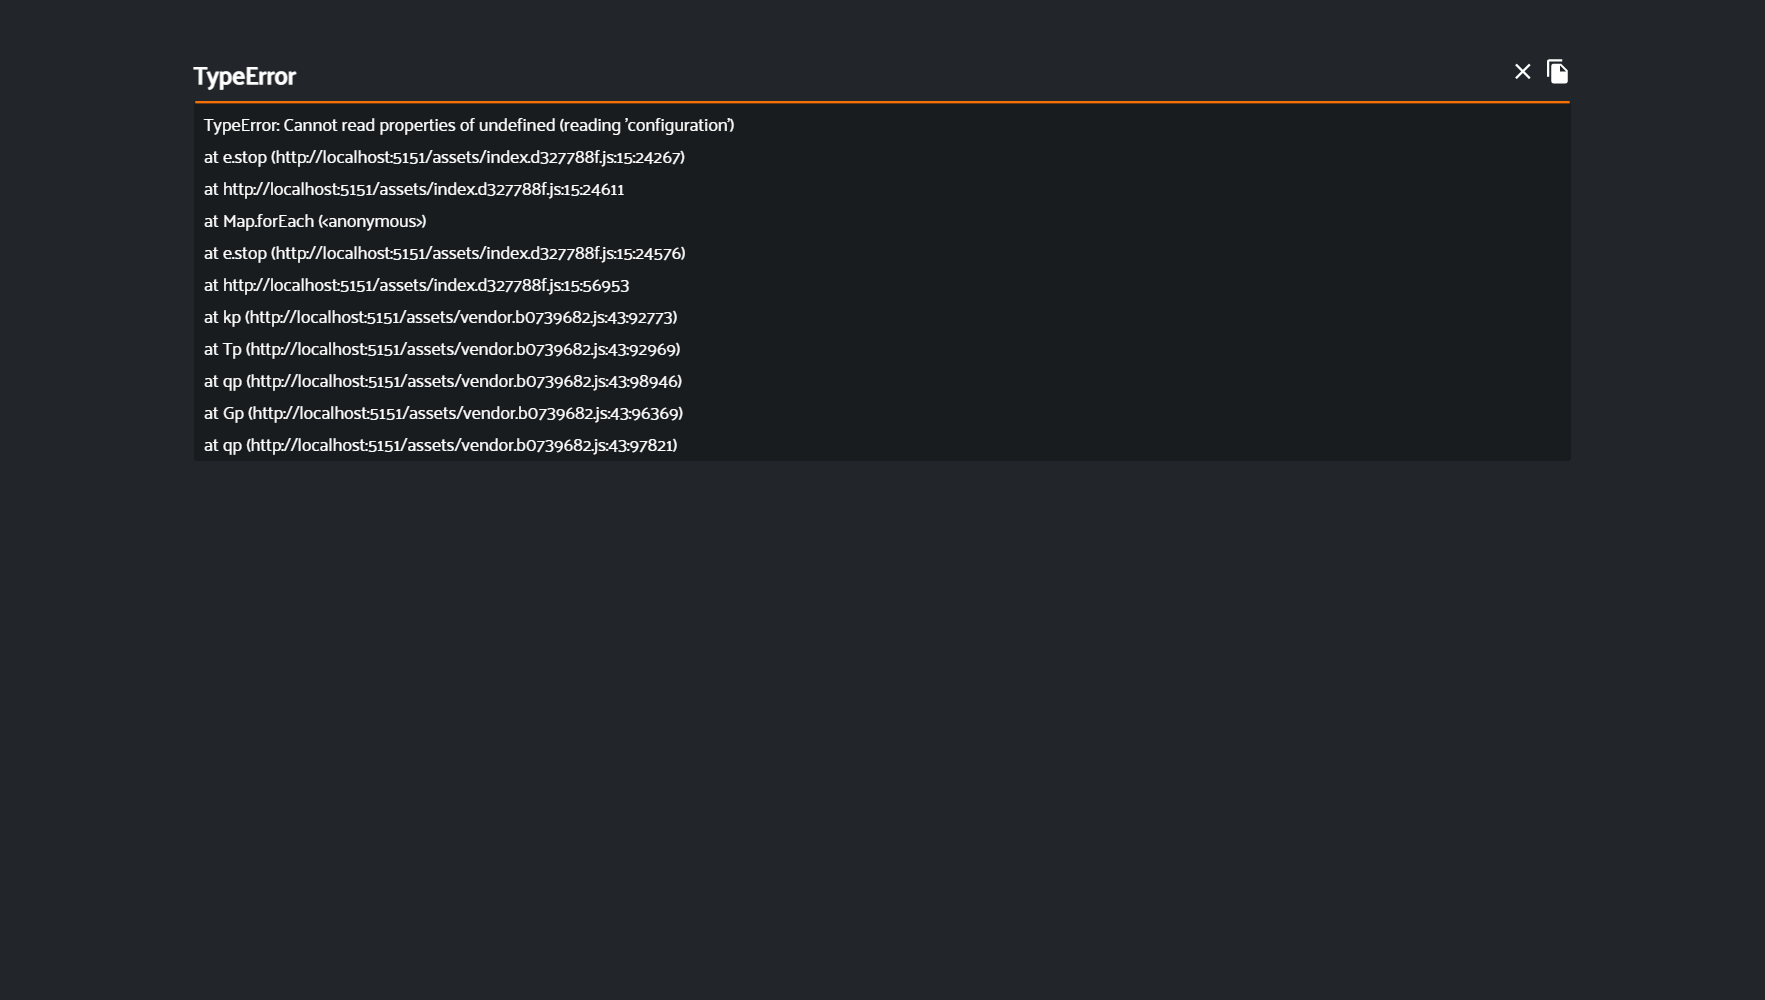

In [68]:
session = fo.launch_app(dataset.match(F("gpt3_mistakeness") > 0.757))

### Evaluating Predictions of Models

In [54]:
def evaluate_model(model_prefix: str):
    print(f"***\nEvaluation Results For {model_prefix.upper()} model:\n***")
    prediction_label = model_prefix + "_prediction"
    eval_key=f"eval_{model_prefix}_binary"

    results = dataset.evaluate_classifications(
        prediction_label,
        gt_field="ground_truth",
        eval_key=eval_key,
        method="binary",
        classes=classes,
    )

    results.print_report()

    plot = results.plot_pr_curve()
    plot.show()
    
    conf_plot = results.plot_confusion_matrix()
    conf_plot.show()

In [15]:
evaluate_model("bert")

***
Evaluation Results For BERT model:
***
                 precision    recall  f1-score   support

Not_Checkworthy       0.75      0.70      0.72        80
    Checkworthy       0.63      0.68      0.66        60

       accuracy                           0.69       140
      macro avg       0.69      0.69      0.69       140
   weighted avg       0.70      0.69      0.69       140



FigureWidget({
    'data': [{'customdata': array([0.572932  , 0.6093414 , 0.6666847 , 0.69903913, 0.7764561 , …

FigureWidget({
    'data': [{'mode': 'markers',
              'opacity': 0.1,
              'type': 'scatter',…



Could not connect session, trying again in 10 seconds



In [16]:
evaluate_model("roberta")

***
Evaluation Results For ROBERTA model:
***
                 precision    recall  f1-score   support

Not_Checkworthy       0.84      0.78      0.81        80
    Checkworthy       0.73      0.80      0.76        60

       accuracy                           0.79       140
      macro avg       0.78      0.79      0.78       140
   weighted avg       0.79      0.79      0.79       140



FigureWidget({
    'data': [{'customdata': array([0.56247944, 0.5634323 , 0.58569556, 0.59688774, 0.62889504, …

FigureWidget({
    'data': [{'mode': 'markers',
              'opacity': 0.1,
              'type': 'scatter',…

In [44]:
evaluate_model("bertweet")

***
Evaluation Results For BERTWEET model:
***
                 precision    recall  f1-score   support

Not_Checkworthy       0.78      0.80      0.79        80
    Checkworthy       0.72      0.70      0.71        60

       accuracy                           0.76       140
      macro avg       0.75      0.75      0.75       140
   weighted avg       0.76      0.76      0.76       140



FigureWidget({
    'data': [{'customdata': array([0.55340412, 0.60111934, 0.60657996, 0.63541842, 0.6430512 , …

FigureWidget({
    'data': [{'mode': 'markers',
              'opacity': 0.1,
              'type': 'scatter',…

In [40]:
evaluate_model("bertweet_filtered")

***
Evaluation Results For BERTWEET_FILTERED model:
***
                 precision    recall  f1-score   support

Not_Checkworthy       0.90      0.88      0.89        64
    Checkworthy       0.83      0.86      0.84        44

       accuracy                           0.87       108
      macro avg       0.86      0.87      0.87       108
   weighted avg       0.87      0.87      0.87       108



FigureWidget({
    'data': [{'customdata': array([0.54115033, 0.6466267 , 0.67006543, 0.73167884, 0.73577774, …

FigureWidget({
    'data': [{'mode': 'markers',
              'opacity': 0.1,
              'type': 'scatter',…

In [62]:
evaluate_model("gpt3")

***
Evaluation Results For GPT3 model:
***
                 precision    recall  f1-score   support

Not_Checkworthy       0.78      0.81      0.80        80
    Checkworthy       0.74      0.70      0.72        60

       accuracy                           0.76       140
      macro avg       0.76      0.76      0.76       140
   weighted avg       0.76      0.76      0.76       140



FigureWidget({
    'data': [{'customdata': array([2.79674129e-05, 4.54932582e-05, 5.88439366e-05, 7.76776229e-…

FigureWidget({
    'data': [{'mode': 'markers',
              'opacity': 0.1,
              'type': 'scatter',…

## FIFTYONE BRAIN

In [47]:
import fiftyone.brain as fob

### Computing Sample hardness

In [60]:
fob.compute_hardness(dataset, "gpt3_prediction")

Computing hardness...
 100% |█████████████████| 140/140 [218.9ms elapsed, 0s remaining, 639.7 samples/s]      
Hardness computation complete


In [49]:
model_prefix_list = ["bert", "roberta", "bertweet", "gpt3"]

for prefix in model_prefix_list:
    fob.compute_mistakenness(dataset, prefix+"_prediction", label_field="ground_truth", mistakenness_field=prefix+"_mistakeness", use_logits=True)

Computing mistakenness...
 100% |█████████████████| 140/140 [250.2ms elapsed, 0s remaining, 559.5 samples/s]      
Mistakenness computation complete
Computing mistakenness...
 100% |█████████████████| 140/140 [273.8ms elapsed, 0s remaining, 511.3 samples/s]      
Mistakenness computation complete
Computing mistakenness...
 100% |█████████████████| 140/140 [270.2ms elapsed, 0s remaining, 518.2 samples/s]      
Mistakenness computation complete
Computing mistakenness...
 100% |█████████████████| 140/140 [239.3ms elapsed, 0s remaining, 585.1 samples/s]      
Mistakenness computation complete


In [13]:
embeddings_list = eval_df["embeddings"].tolist()
pca = PCA(n_components=10)
PCA_result = pca.fit_transform(embeddings_list)
PCA_df = pd.DataFrame(PCA_result)
tsne = TSNE(n_components=2, random_state=42)
Y = tsne.fit_transform(PCA_df)


c:\Users\cemul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_pca.py:630: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var
c:\Users\cemul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\cemul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [14]:
results_manual = fob.compute_visualization(
    dataset,
    points=Y ,
    num_dims=2,
    brain_key="embeddings_manual",
    method="manual"
)

In [15]:
results_umap = fob.compute_visualization(
    dataset,
    embeddings=eval_df.embeddings,
    num_dims=2,
    brain_key="embeddings_umap",
    verbose=True,
    seed=51,
    method="umap"
)
results_tsne = fob.compute_visualization(
    dataset,
    embeddings=eval_df.embeddings,
    num_dims=2,
    brain_key="embeddings_tsne",
    verbose=True,
    seed=51,
    method="tsne"
)
results_pca = fob.compute_visualization(
    dataset,
    embeddings=eval_df.embeddings,
    num_dims=2,
    brain_key="embeddings_pca",
    verbose=True,
    seed=51,
    method="pca"
)
#results_manual = fob.compute_visualization(
#    dataset,
#    embeddings=eval_df.embeddings,
#    num_dims=2,
#    brain_key="embeddings_manual",
#    verbose=True,
#    seed=51,
#    method="manual"
#)

Generating visualization...
UMAP(random_state=51, verbose=True)
Thu Sep 22 09:45:12 2022 Construct fuzzy simplicial set
Thu Sep 22 09:45:12 2022 Finding Nearest Neighbors
Thu Sep 22 09:45:15 2022 Finished Nearest Neighbor Search
Thu Sep 22 09:45:17 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Sep 22 09:45:19 2022 Finished embedding
Generating visualization...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 140 samples in 0.000s...
[t-SNE] Computed neighbors for 140 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 140 / 140
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.007s
[t-SNE] Iteration 50: error = -518.9831543, gradient norm = 0.0000000 (50 iterations in 0.012s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: -518.983154
[t-SNE] Iteration 100: error = -45.7335205, gradient norm = 0.0000000 (50 iterations in 0.013s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 100 iterations: -45.733521
Ignoring unsupported parameters {'verbose'} for <class 'fiftyone.brain.visualization.PCAVisualizationConfig'>
Generating visualization...


c:\Users\cemul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_pca.py:630: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var
c:\Users\cemul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_pca.py:630: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var
c:\Users\cemul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
c:\Users\cemul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_pca.py:630: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


In [33]:
print(type(results))
print(results.points.shape)

<class 'fiftyone.brain.visualization.VisualizationResults'>
(140, 2)


In [34]:
session = fo.launch_app(dataset)

In [16]:
# Plot embeddings colored by ground truth label
plot_umap = results_umap.visualize(labels="ground_truth.label")
plot_tsne = results_tsne.visualize(labels="ground_truth.label")
plot_manual = results_manual.visualize(labels="ground_truth.label")

plot_umap.show(height=720)
plot_tsne.show(height=720)
plot_manual.show(height=720)

# Attach plot to session
session.plots.attach(plot_umap)

FigureWidget({
    'data': [{'customdata': array(['632c04494996ed952b922346', '632c04494996ed952b922367',
    …

FigureWidget({
    'data': [{'customdata': array(['632c04494996ed952b922346', '632c04494996ed952b922367',
    …

FigureWidget({
    'data': [{'customdata': array(['632c04494996ed952b922346', '632c04494996ed952b922367',
    …

NameError: name 'session' is not defined

In [19]:
print(dataset.list_brain_runs())

['image_embeddings']


In [45]:
# Sort by likelihood of mistake (most likely first)
mistake_view = (dataset
    .sort_by("mistakenness", reverse=True)
)

# Print some information about the view
print(mistake_view)

ValueError: Field 'mistakenness' does not exist

In [64]:
print(mistake_view.head())

[<SampleView: {
    'id': '63248dcc0fb9082b16cd666a',
    'media_type': 'image',
    'filepath': 'c:\\repos\\Transformers_For_Claim_Worthiness\\data\\img\\1237234567423107077.png',
    'tags': BaseList(['Validation']),
    'metadata': <ImageMetadata: {
        'size_bytes': 11520,
        'mime_type': 'image/png',
        'width': 256,
        'height': 256,
        'num_channels': 3,
    }>,
    'ground_truth': <Classification: {
        'id': '63248dcc0fb9082b16cd6666',
        'tags': BaseList([]),
        'label': 'Checkworthy',
        'confidence': None,
        'logits': None,
        'binary_label': 1,
    }>,
    'bert_prediction': <Classification: {
        'id': '63248dcc0fb9082b16cd6667',
        'tags': BaseList([]),
        'label': 'Not_Checkworthy',
        'confidence': 0.000120559474,
        'logits': array([1.20559474e-04, 9.99879441e-01]),
        'binary_label': 0,
    }>,
    'roberta_prediction': <Classification: {
        'id': '63248dcc0fb9082b16cd6668',
     

In [ ]:
session.view = dataset.sort_by("mistakenness")

In [67]:
session = fo.launch_app(dataset, desktop=True)

ValueError: Cannot open a Desktop App instance from a IPYTHON notebook

### FINDING CLASSIFICATION MISTAKES WITH FIFTYONE